<a href="https://colab.research.google.com/github/Emmnmm/HW8/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

# Q1

In [5]:
# Load the dataset
df = pd.read_csv("diabetes_dataset.csv")

In [6]:
# Define the outcome (target) and predictors (features)
target_column = "Outcome"  # Assuming "Outcome" is the binary target variable
X = df.drop(columns=[target_column])  # Predictor variables
y = df[target_column].values  # Target variable

# Standardize predictors for better sampling efficiency
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of predictors
p = X_scaled.shape[1]

# Bayesian Logistic Regression Model
with pm.Model() as model:
    # Priors for regression coefficients (betas) and intercept
    betas = pm.Normal("betas", mu=0, sigma=1, shape=p)
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    # Logit link function
    logits = intercept + pm.math.dot(X_scaled, betas)

    # Likelihood function (Bernoulli outcome)
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y)

    # MCMC Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)


Output()

In [8]:
az.summary(trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.414,0.105,0.218,0.620,0.002,0.001,3630.0,2935.0,1.0
betas[1],1.123,0.113,0.918,1.353,0.002,0.001,2875.0,2820.0,1.0
betas[2],-0.254,0.100,-0.435,-0.047,0.002,0.001,3966.0,3230.0,1.0
betas[3],0.009,0.112,-0.209,0.214,0.002,0.002,3424.0,3244.0,1.0
betas[4],-0.134,0.105,-0.334,0.073,0.002,0.001,3487.0,3098.0,1.0
betas[5],0.709,0.117,0.475,0.934,0.002,0.001,3605.0,3114.0,1.0
betas[6],0.315,0.099,0.106,0.493,0.001,0.001,4437.0,2680.0,1.0
betas[7],0.180,0.110,-0.030,0.396,0.002,0.001,3143.0,3047.0,1.0
intercept,-0.869,0.098,-1.061,-0.675,0.002,0.001,4108.0,3036.0,1.0


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

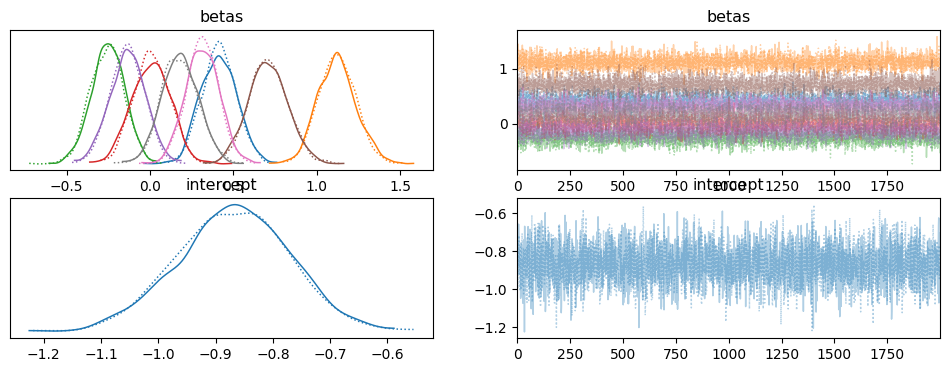

In [9]:
az.plot_trace(trace)

This model uses the [diabetes](https://www.kaggle.com/datasets/hasibur013/diabetes-dataset?resource=download) dataset from kaggle. With the target variable being the outcome where 1 indicates diabetes -> 0 indicates no diabetes and predictors being the remaining variables in the dataset : Pregnancies, Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Diabetes Pedigree Function, Age . <br> With the summary table giving us the mean and 95% credible intervals for our regression coefficients (betas) .<br>
  E.g. b0 having a mean of 0.414 with a 95% credible interval of [0.218,0.620]-> b1 having a mean of 1.123 with a 95% credible interval of [0.918,1.353]-> b2 having a mean of -0.254 with a 95% credible interval of [-0.435,-0.047]-> b3 having a mean of 0.009 with a 95% credible interval of [-0.209,0.214]-> b4 having a mean of -0.134 with a 95% credible interval of [-0.334,0.073]-> b5 having a mean of 0.709 with a 95% credible interval of [0.475,0.934]-> b6 having a mean of 0.315 with a 95% credible interval of [0.106,0.493]-> b7 having a mean of 0.180 with a 95% credible interval of [-0.030,0.396]<br>
  For MCMC diagnostics , we can see that all our r_hats are close to 1 suggesting good convergence which is further reflected in the trace plots by their smooth mixing. We also have a large effective sample size as indicated by ess_bulk , ess_tail all being above 2000 indicating reliable posterior estimates with low autocorrelation.

# Q2


In [29]:
# Load the dataset
df = pd.read_csv("winequalityN.csv")
df.dropna(inplace=True)
df.head()





,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Playing around with values

In [6]:

# Choose predictors and outcomes
predictors = ['density', 'alcohol', 'citric acid', 'residual sugar', 'chlorides']
outcomes = ['quality', 'fixed acidity']  # Two outcomes

# Downsample
df_sample = df.sample(n=500, random_state=42)

# Standardize predictors and outcomes
X = stats.zscore(df_sample[predictors].values)  # (n, p)
y = stats.zscore(df_sample[outcomes].values)  # (n, m)

# Get dimensions
n, p = X.shape  # n=500, p=5
m = y.shape[1]  # m=2 (two outcomes)
a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()
# Build Bayesian model
with pm.Model() as wine_quality_model:
    # LKJ Cholesky Covariance prior for covariance matrix L
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)  # Convert packed L to full lower triangular matrix

    # Normal prior for regression coefficients (betas) with shape (p, m)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # Covariance matrix (Deterministic)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Covariance matrix from Cholesky decomposition

    # Multivariate normal likelihood for outcomes (y)
    y_obs = pm.MvNormal('y_obs', mu=X @ betas, chol=L, observed=y)  # Likelihood with Cholesky factor

    # Sampling
    idata = pm.sample(1000, return_inferencedata=True, chains=4, target_accept=0.9) ; # Use 4 chains for better diagnostics





Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.699,0.045,0.611,0.789,0.001,0.000,5461.0,3137.0,1.0
"Sigma[0, 1]",0.010,0.023,-0.033,0.055,0.000,0.000,4958.0,2844.0,1.0
"Sigma[1, 0]",0.010,0.023,-0.033,0.055,0.000,0.000,4958.0,2844.0,1.0
"Sigma[1, 1]",0.360,0.022,0.315,0.402,0.000,0.000,5077.0,3012.0,1.0
"betas[0, 0]",-0.110,0.064,-0.240,0.011,0.001,0.001,3337.0,2846.0,1.0
"betas[0, 1]",1.089,0.046,0.996,1.174,0.001,0.001,3102.0,2755.0,1.0
"betas[1, 0]",0.482,0.054,0.377,0.585,0.001,0.001,4148.0,3298.0,1.0
"betas[1, 1]",0.447,0.038,0.373,0.518,0.001,0.000,4035.0,3340.0,1.0
"betas[2, 0]",0.146,0.038,0.070,0.220,0.001,0.000,4696.0,3345.0,1.0
"betas[2, 1]",0.328,0.026,0.278,0.381,0.000,0.000,5136.0,2713.0,1.0


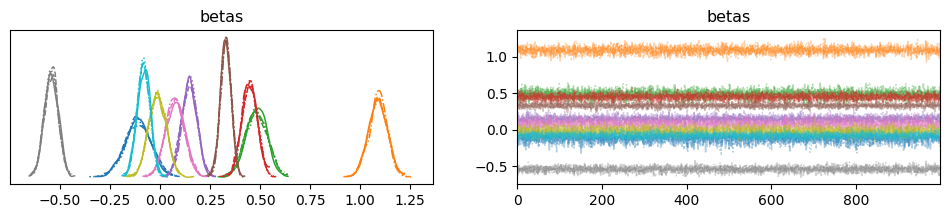

In [10]:
az.plot_trace(idata, var_names=['betas'])
az.summary(idata, hdi_prob=0.95)

In [13]:
predictors = ['density', 'alcohol', 'citric acid']  # Only 3 predictors
outcomes = ['quality', 'fixed acidity']  # Two outcomes

# Downsample to n=500
df_sample = df.sample(n=500, random_state=42)

# Standardize predictors and outcomes
X = stats.zscore(df_sample[predictors].values)  # (n=500, p=3)
y = stats.zscore(df_sample[outcomes].values)  # (n=500, m=2)

# Get dimensions
n, p = X.shape  # n=500, p=3
m = y.shape[1]  # m=2 (two outcomes)

a_cov2 = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()


with pm.Model() as wine_quality_model:
    # LKJ Cholesky Covariance prior for covariance matrix L
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)  # Convert packed L to full lower triangular matrix

    # Normal prior for regression coefficients (betas) with shape (p, m)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # Covariance matrix (Deterministic)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Covariance matrix from Cholesky decomposition

    # Multivariate normal likelihood for outcomes (y)
    y_obs = pm.MvNormal('y_obs', mu=X @ betas, chol=L, observed=y)  # Likelihood with Cholesky factor

    # Sampling
    idata2 = pm.sample(1000, return_inferencedata=True, chains=4, target_accept=0.9)  # Use 4 chains for better diagnostics



Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.703,0.046,0.615,0.794,0.001,0.000,5404.0,3289.0,1.0
"Sigma[0, 1]",-0.019,0.029,-0.075,0.035,0.000,0.000,6007.0,2955.0,1.0
"Sigma[1, 0]",-0.019,0.029,-0.075,0.035,0.000,0.000,6007.0,2955.0,1.0
"Sigma[1, 1]",0.558,0.036,0.489,0.633,0.000,0.000,6448.0,2810.0,1.0
"betas[0, 0]",-0.075,0.053,-0.177,0.032,0.001,0.001,2867.0,3215.0,1.0
"betas[0, 1]",0.775,0.048,0.680,0.868,0.001,0.001,3549.0,3247.0,1.0
"betas[1, 0]",0.485,0.053,0.385,0.594,0.001,0.001,2938.0,2791.0,1.0
"betas[1, 1]",0.435,0.047,0.343,0.524,0.001,0.001,3567.0,3249.0,1.0
"betas[2, 0]",0.153,0.038,0.077,0.224,0.000,0.000,6132.0,2986.0,1.0
"betas[2, 1]",0.292,0.034,0.226,0.356,0.000,0.000,5873.0,2978.0,1.0


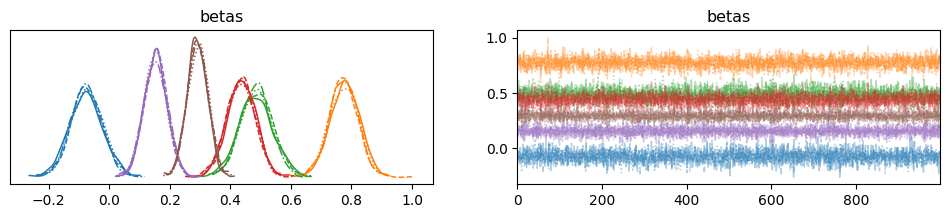

In [14]:
az.plot_trace(idata2, var_names=['betas'])
az.summary(idata2, hdi_prob=0.95)

In [17]:
predictors = ['density', 'alcohol', 'citric acid', 'residual sugar', 'chlorides'] # p = 5
outcomes = ['quality', 'fixed acidity','pH','sulphates']  # m = 4

# Downsample to n=500
df_sample = df.sample(n=500, random_state=42)

# Standardize predictors and outcomes
X = stats.zscore(df_sample[predictors].values)  # (n=500, p=5)
y = stats.zscore(df_sample[outcomes].values)  # (n=500, m=2)

# Get dimensions
n, p = X.shape  # n=500, p=5
m = y.shape[1]  # m=4 (four outcomes)

a_cov3 = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()


with pm.Model() as wine_quality_model:
    # LKJ Cholesky Covariance prior for covariance matrix L
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)  # Convert packed L to full lower triangular matrix

    # Normal prior for regression coefficients (betas) with shape (p, m)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # Covariance matrix (Deterministic)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Covariance matrix from Cholesky decomposition

    # Multivariate normal likelihood for outcomes (y)
    y_obs = pm.MvNormal('y_obs', mu=X @ betas, chol=L, observed=y)  # Likelihood with Cholesky factor

    # Sampling
    idata3 = pm.sample(1000, return_inferencedata=True, chains=4, target_accept=0.9)  # Use 4 chains for better diagnostics



Output()

/usr/local/lib/python3.11/dist-packages/pytensor/tensor/subtensor.py:2585: RuntimeWarning: invalid value 
encountered in add
  np.add.at(x, idx, y)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.703,0.044,0.616,0.788,0.001,0.000,6454.0,3152.0,1.0
"Sigma[0, 1]",0.011,0.022,-0.034,0.054,0.000,0.000,3763.0,3025.0,1.0
"Sigma[0, 2]",0.021,0.033,-0.046,0.082,0.001,0.000,3817.0,3367.0,1.0
"Sigma[0, 3]",0.106,0.031,0.049,0.172,0.000,0.000,6233.0,3624.0,1.0
"Sigma[1, 0]",0.011,0.022,-0.034,0.054,0.000,0.000,3763.0,3025.0,1.0
"Sigma[1, 1]",0.359,0.023,0.316,0.404,0.000,0.000,4038.0,2884.0,1.0
"Sigma[1, 2]",-0.378,0.028,-0.432,-0.321,0.000,0.000,3428.0,2319.0,1.0
"Sigma[1, 3]",-0.114,0.023,-0.156,-0.067,0.000,0.000,5041.0,3086.0,1.0
"Sigma[2, 0]",0.021,0.033,-0.046,0.082,0.001,0.000,3817.0,3367.0,1.0
"Sigma[2, 1]",-0.378,0.028,-0.432,-0.321,0.000,0.000,3428.0,2319.0,1.0


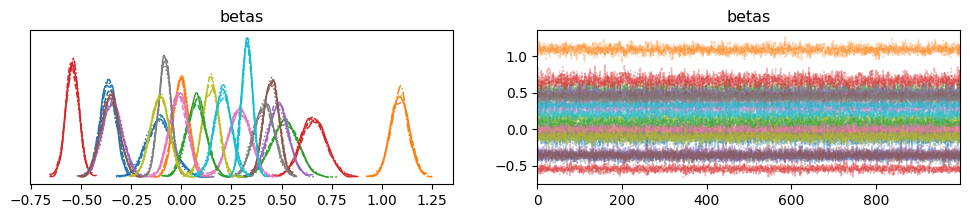

In [18]:
az.plot_trace(idata3, var_names=['betas'])
az.summary(idata3, hdi_prob=0.95)

In [20]:
predictors = ['density', 'alcohol', 'citric acid']  # Only 3 predictors
outcomes = ['quality', 'fixed acidity']  # Two outcomes

# Downsample to n=200
df_sample = df.sample(n=200, random_state=42)

# Standardize predictors and outcomes
X = stats.zscore(df_sample[predictors].values)  # (n=200, p=3)
y = stats.zscore(df_sample[outcomes].values)  # (n=200, m=2)

# Get dimensions
n, p = X.shape  # n=200, p=3
m = y.shape[1]  # m=2 (two outcomes)

a_cov4 = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()


with pm.Model() as wine_quality_model:
    # LKJ Cholesky Covariance prior for covariance matrix L
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)  # Convert packed L to full lower triangular matrix

    # Normal prior for regression coefficients (betas) with shape (p, m)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # Covariance matrix (Deterministic)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Covariance matrix from Cholesky decomposition

    # Multivariate normal likelihood for outcomes (y)
    y_obs = pm.MvNormal('y_obs', mu=X @ betas, chol=L, observed=y)  # Likelihood with Cholesky factor

    # Sampling
    idata4 = pm.sample(1000, return_inferencedata=True, chains=4, target_accept=0.9)  # Use 4 chains for better diagnostics



Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.723,0.074,0.587,0.869,0.001,0.001,5697.0,2986.0,1.0
"Sigma[0, 1]",0.016,0.044,-0.073,0.097,0.001,0.001,5868.0,3087.0,1.0
"Sigma[1, 0]",0.016,0.044,-0.073,0.097,0.001,0.001,5868.0,3087.0,1.0
"Sigma[1, 1]",0.534,0.053,0.432,0.633,0.001,0.000,6396.0,3391.0,1.0
"betas[0, 0]",-0.098,0.081,-0.264,0.056,0.001,0.001,3202.0,2514.0,1.0
"betas[0, 1]",0.778,0.071,0.647,0.919,0.001,0.001,3250.0,3054.0,1.0
"betas[1, 0]",0.454,0.082,0.291,0.612,0.001,0.001,3424.0,2984.0,1.0
"betas[1, 1]",0.426,0.070,0.290,0.558,0.001,0.001,3523.0,3012.0,1.0
"betas[2, 0]",0.185,0.060,0.069,0.308,0.001,0.001,5806.0,3114.0,1.0
"betas[2, 1]",0.306,0.053,0.208,0.414,0.001,0.000,6742.0,3028.0,1.0


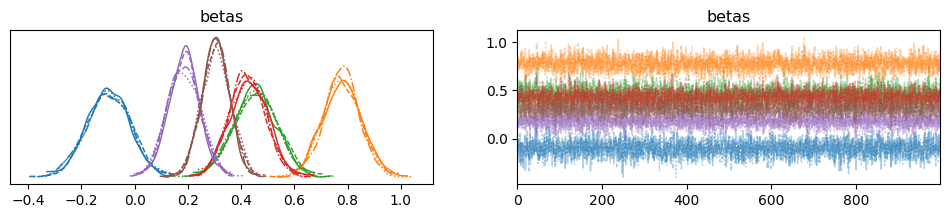

In [21]:
az.plot_trace(idata4, var_names=['betas'])
az.summary(idata4, hdi_prob=0.95)

In [22]:
predictors = ['density', 'alcohol', 'citric acid', 'residual sugar', 'chlorides']
outcomes = ['quality', 'fixed acidity']  # Two outcomes

# Downsample to n=200
df_sample = df.sample(n=200, random_state=42)

# Standardize predictors and outcomes
X = stats.zscore(df_sample[predictors].values)  # (n=200, p=5)
y = stats.zscore(df_sample[outcomes].values)  # (n=200, m=2)

# Get dimensions
n, p = X.shape  # n=200, p=5
m = y.shape[1]  # m=2 (two outcomes)

a_cov5 = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()


with pm.Model() as wine_quality_model:
    # LKJ Cholesky Covariance prior for covariance matrix L
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)  # Convert packed L to full lower triangular matrix

    # Normal prior for regression coefficients (betas) with shape (p, m)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # Covariance matrix (Deterministic)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Covariance matrix from Cholesky decomposition

    # Multivariate normal likelihood for outcomes (y)
    y_obs = pm.MvNormal('y_obs', mu=X @ betas, chol=L, observed=y)  # Likelihood with Cholesky factor

    # Sampling
    idata5 = pm.sample(1000, return_inferencedata=True, chains=4, target_accept=0.9)  # Use 4 chains for better diagnostics



Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.725,0.074,0.586,0.875,0.001,0.001,4787.0,3046.0,1.0
"Sigma[0, 1]",0.024,0.036,-0.048,0.092,0.001,0.000,4937.0,3387.0,1.0
"Sigma[1, 0]",0.024,0.036,-0.048,0.092,0.001,0.000,4937.0,3387.0,1.0
"Sigma[1, 1]",0.349,0.036,0.283,0.420,0.001,0.000,4643.0,3154.0,1.0
"betas[0, 0]",-0.155,0.103,-0.358,0.038,0.002,0.001,2779.0,2558.0,1.0
"betas[0, 1]",1.076,0.072,0.939,1.221,0.001,0.001,3187.0,2724.0,1.0
"betas[1, 0]",0.450,0.083,0.288,0.611,0.001,0.001,3684.0,3038.0,1.0
"betas[1, 1]",0.425,0.057,0.313,0.534,0.001,0.001,3954.0,3154.0,1.0
"betas[2, 0]",0.186,0.061,0.067,0.304,0.001,0.001,4495.0,3333.0,1.0
"betas[2, 1]",0.322,0.042,0.239,0.404,0.001,0.000,4840.0,3209.0,1.0


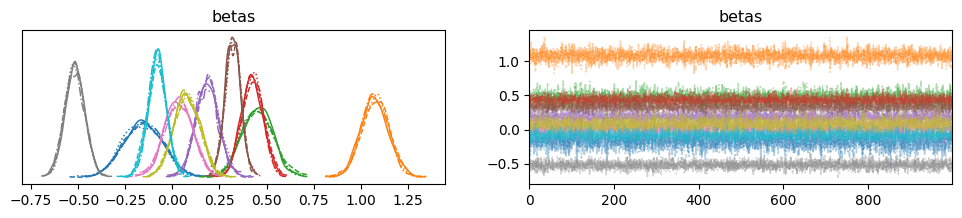

In [24]:
az.plot_trace(idata5, var_names=['betas'])
az.summary(idata5, hdi_prob=0.95)

In [27]:
predictors = ['density', 'alcohol', 'citric acid']
outcomes = ['quality', 'fixed acidity']  # Two outcomes

# Downsample to n=100
df_sample = df.sample(n=100, random_state=42)

# Standardize predictors and outcomes
X = stats.zscore(df_sample[predictors].values)  # (n=100, p=3)
y = stats.zscore(df_sample[outcomes].values)  # (n=100, m=2)

# Get dimensions
n, p = X.shape  # n=100, p=3
m = y.shape[1]  # m=2 (two outcomes)

a_cov6 = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()


with pm.Model() as wine_quality_model:
    # LKJ Cholesky Covariance prior for covariance matrix L
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)  # Convert packed L to full lower triangular matrix

    # Normal prior for regression coefficients (betas) with shape (p, m)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # Covariance matrix (Deterministic)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Covariance matrix from Cholesky decomposition

    # Multivariate normal likelihood for outcomes (y)
    y_obs = pm.MvNormal('y_obs', mu=X @ betas, chol=L, observed=y)  # Likelihood with Cholesky factor

    # Sampling
    idata6 = pm.sample(1000, return_inferencedata=True, chains=4, target_accept=0.9)  # Use 4 chains for better diagnostics



Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.691,0.102,0.514,0.907,0.002,0.001,3993.0,3093.0,1.0
"Sigma[0, 1]",0.115,0.045,0.030,0.202,0.001,0.001,4045.0,3195.0,1.0
"Sigma[1, 0]",0.115,0.045,0.030,0.202,0.001,0.001,4045.0,3195.0,1.0
"Sigma[1, 1]",0.275,0.041,0.202,0.358,0.001,0.000,4070.0,3005.0,1.0
"betas[0, 0]",-0.143,0.128,-0.391,0.097,0.002,0.002,3178.0,2859.0,1.0
"betas[0, 1]",1.089,0.084,0.915,1.244,0.002,0.001,2596.0,2697.0,1.0
"betas[1, 0]",0.476,0.109,0.262,0.693,0.002,0.001,3960.0,3210.0,1.0
"betas[1, 1]",0.404,0.069,0.265,0.535,0.001,0.001,3718.0,2832.0,1.0
"betas[2, 0]",0.207,0.085,0.048,0.384,0.001,0.001,4145.0,2947.0,1.0
"betas[2, 1]",0.287,0.054,0.186,0.394,0.001,0.001,3583.0,3093.0,1.0


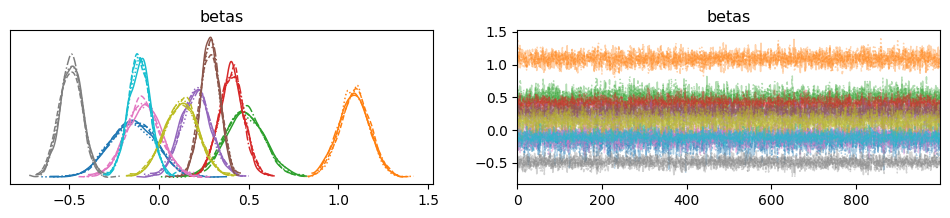

In [26]:
az.plot_trace(idata6, var_names=['betas'])
az.summary(idata6, hdi_prob=0.95)

# Findings
* Predictors and Outcomes: Increasing the values of m (number of outcomes) and p (number of predictors) leads to a significantly longer run time. However, higher values of m have a much larger effect on run time than p.

* Sample Size: Reducing the sample size (n) slightly decreases the run time. Across all values of n, R-hat remains 1 and the effective sample size (ESS) stays large, suggesting that the model is not highly sensitive to changes in n.

* Predictors: Reducing the number of predictors from 5 to 3 results in an increase in the standard deviation of the prediction intervals, suggesting a decrease in the model's predictive accuracy.





Conclusion:<br> Given the above findings, I will use the model with n = 100, p = 5, and m = 2 as my final, "reasonably small" data set.

In [30]:
predictors = ['density', 'alcohol', 'citric acid', 'residual sugar', 'chlorides']
outcomes = ['quality', 'fixed acidity']  # Two outcomes

n=100
df_sample = df.sample(n=100, random_state=42)

# Standardize predictors and outcomes
X = stats.zscore(df_sample[predictors].values)  # (n=100, p=5)
y = stats.zscore(df_sample[outcomes].values)  # (n=100, m=2)

# Get dimensions
n, p = X.shape  # n=100, p=5
m = y.shape[1]  # m=2 (two outcomes)

a_cov_f = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()


with pm.Model() as wine_quality_model:
    # LKJ Cholesky Covariance prior for covariance matrix L
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)  # Convert packed L to full lower triangular matrix

    # Normal prior for regression coefficients (betas) with shape (p, m)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # Covariance matrix (Deterministic)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Covariance matrix from Cholesky decomposition

    # Multivariate normal likelihood for outcomes (y)
    y_obs = pm.MvNormal('y_obs', mu=X @ betas, chol=L, observed=y)  # Likelihood with Cholesky factor

    # Sampling
    idata_f = pm.sample(1000, return_inferencedata=True, chains=4, target_accept=0.9)  # Use 4 chains for better diagnostics



Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.692,0.106,0.498,0.907,0.002,0.001,4177.0,3030.0,1.0
"Sigma[0, 1]",0.117,0.047,0.027,0.209,0.001,0.001,4330.0,3007.0,1.0
"Sigma[1, 0]",0.117,0.047,0.027,0.209,0.001,0.001,4330.0,3007.0,1.0
"Sigma[1, 1]",0.275,0.040,0.204,0.356,0.001,0.000,3830.0,2657.0,1.0
"betas[0, 0]",-0.147,0.132,-0.430,0.099,0.002,0.002,2996.0,2415.0,1.0
"betas[0, 1]",1.088,0.087,0.914,1.251,0.002,0.001,3038.0,2687.0,1.0
"betas[1, 0]",0.474,0.109,0.262,0.689,0.002,0.001,3458.0,2792.0,1.0
"betas[1, 1]",0.403,0.069,0.267,0.535,0.001,0.001,3939.0,3297.0,1.0
"betas[2, 0]",0.209,0.086,0.036,0.368,0.001,0.001,3948.0,3153.0,1.0
"betas[2, 1]",0.286,0.055,0.185,0.403,0.001,0.001,4271.0,3017.0,1.0


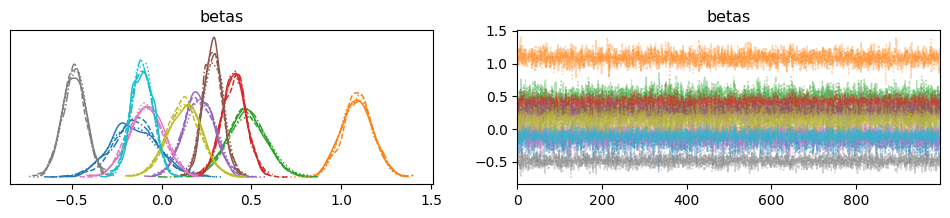

In [31]:
az.plot_trace(idata_f, var_names=['betas'])
az.summary(idata_f, hdi_prob=0.95)

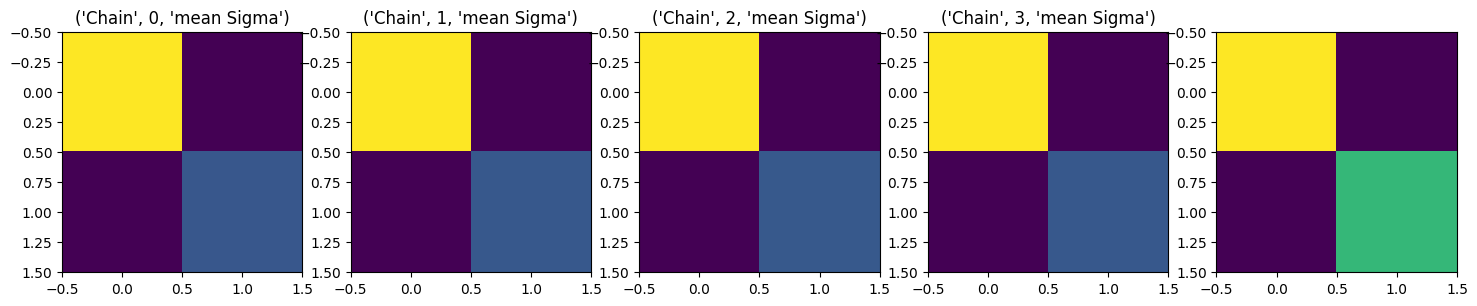

In [34]:
fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov_f)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata_f.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("Chain",chain,"mean Sigma"))



*   All r_hat values are equal to 1 -> indicating good convergence across chains
*   Ess values are all larger than 2000 -> showing that the posterior estimates are reliable
*   The mcse values are also quite small for all parameters suggesting that the estimates are fairly precise.



# Q3

In [69]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler


In [3]:


# Load dataset
df = pd.read_csv("diabetes_dataset.csv")

# Drop rows with missing values
df_clean = df.dropna()
# make pregenacy binary 0 for never ; 1 for everything else
df['Pregnancies'] = np.where(df['Pregnancies'] > 1, 1, 0)
# Modify 'BMI' to a binary variable where BMI > 30 is 1 and BMI <= 30 is 0
df['BMI'] = np.where(df['BMI'] > 30, 1, 0)


In [6]:
# Downsample the dataset to 100 samples
df_downsampled = df.sample(n=100, random_state=42)

# Define X by listing desired predictor columns explicitly
X_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
X = df_downsampled[X_columns]

# Define Y by explicitly listing Pregnancies, BMI, and Outcome (all binary)
Y_columns = ['Pregnancies', 'BMI', 'Outcome']
Y = df_downsampled[Y_columns]

# Standardize the features (X only)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Get the number of samples (n) and predictors (p) from X
n, p = X_standardized.shape

# Get the number of binary outcomes (m) from Y
m = Y.shape[1]

# Define the Bayesian model
with pm.Model() as GLM:
    # Cholesky decomposition of the covariance matrix
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Prior for regression coefficients (betas)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent variable Z (normally distributed)
    z = pm.MvNormal("z", mu=X_standardized @ betas, chol=L, shape=(n, m))

    # Observed binary outcomes with probit link
    y = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=Y)

    # Sample from posterior
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)

Output()

ERROR:pymc.stats.convergence:There were 1404 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [10]:
# Downsample the dataset to 100 samples
df_downsampled = df.sample(n=100, random_state=42)

# Define X by listing desired predictor columns explicitly
X_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
X = df_downsampled[X_columns]
# Define Y to include both 'Outcome' and 'BMI' columns
Y_columns = ['Outcome', 'BMI']
Y = df_downsampled[Y_columns]

# Standardize the features (X only)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Get the number of samples (n) and predictors (p) from X
n, p = X_standardized.shape

# Get the number of binary outcomes (m) from Y
m = Y.shape[1]


with pm.Model() as GLM:

    # Cholesky decomposition of the covariance matrix
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Prior for regression coefficients (Betas)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent variable Z (normally distributed)
    z = pm.MvNormal("z", mu=X_standardized @ betas, chol=L, shape=(n, m))

    # Observed binary outcomes with probit link
    y = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=Y)

    # Sample from posterior
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)


Output()

ERROR:pymc.stats.convergence:There were 1250 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
# Downsample the dataset to 100 samples
df_downsampled = df.sample(n=100, random_state=42)

# Define X by listing desired predictor columns explicitly
X_columns = ['Glucose', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
X = df_downsampled[X_columns]
# Define Y to include both 'Outcome' and 'BMI' columns
Y_columns = ['Outcome', 'BMI']
Y = df_downsampled[Y_columns]

# Standardize the features (X only)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Get the number of samples (n) and predictors (p) from X
n, p = X_standardized.shape

# Get the number of binary outcomes (m) from Y
m = Y.shape[1]


with pm.Model() as GLM:

    # Cholesky decomposition of the covariance matrix
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Prior for regression coefficients (Betas)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent variable Z (normally distributed)
    z = pm.MvNormal("z", mu=X_standardized @ betas, chol=L, shape=(n, m))

    # Observed binary outcomes with probit link
    y = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=Y)

    # Sample from posterior
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)


Output()

ERROR:pymc.stats.convergence:There were 741 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
# Downsample the dataset to 200 samples
df_downsampled = df.sample(n=200, random_state=42)

# Define X by listing desired predictor columns explicitly
X_columns = ['Glucose', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
X = df_downsampled[X_columns]
# Define Y to include both 'Outcome' and 'BMI' columns
Y_columns = ['Outcome', 'BMI']
Y = df_downsampled[Y_columns]

# Standardize the features (X only)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Get the number of samples (n) and predictors (p) from X
n, p = X_standardized.shape

# Get the number of binary outcomes (m) from Y
m = Y.shape[1]


with pm.Model() as GLM:

    # Cholesky decomposition of the covariance matrix
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Prior for regression coefficients (Betas)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent variable Z (normally distributed)
    z = pm.MvNormal("z", mu=X_standardized @ betas, chol=L, shape=(n, m))

    # Observed binary outcomes with probit link
    y = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=Y)

    # Sample from posterior
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)


Output()

ERROR:pymc.stats.convergence:There were 756 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
# Downsample the dataset to 100 samples
df_downsampled = df.sample(n=100, random_state=42)

# Define X by listing desired predictor columns explicitly
X_columns = ['Insulin', 'DiabetesPedigreeFunction', 'Age']
X = df_downsampled[X_columns]
# Define Y to include both 'Outcome' and 'BMI' columns
Y_columns = ['Outcome', 'BMI']
Y = df_downsampled[Y_columns]

# Standardize the features (X only)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Get the number of samples (n) and predictors (p) from X
n, p = X_standardized.shape

# Get the number of binary outcomes (m) from Y
m = Y.shape[1]


with pm.Model() as GLM:

    # Cholesky decomposition of the covariance matrix
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Prior for regression coefficients (Betas)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent variable Z (normally distributed)
    z = pm.MvNormal("z", mu=X_standardized @ betas, chol=L, shape=(n, m))

    # Observed binary outcomes with probit link
    y = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=Y)

    # Sample from posterior
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)

Output()

ERROR:pymc.stats.convergence:There were 764 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Findings
* Nothing seems to decrease the number of convergences more than decreasing the number of outcomes (m) being predicted
* Decreasing the number of predictors also causes a decrease in divergences but not as significant as m
* Number of samples does not seem to have much effect on either runtime or model -> suggesting that issues with divergence is due to complexity of our model rather than sample size
* Runtime wise : high m seems to inflate runtime which might be due to the increase in parameters it has to estimate
----> Choice m=2 p =3 n =100 model

In [7]:
# Downsample the dataset to 100 samples
df_downsampled = df.sample(n=100, random_state=42)

# Define X by listing desired predictor columns explicitly
X_columns = ['Insulin', 'DiabetesPedigreeFunction', 'Age']
X = df_downsampled[X_columns]
# Define Y to include both 'Outcome' and 'BMI' columns
Y_columns = ['Outcome', 'BMI']
Y = df_downsampled[Y_columns]

# Standardize the features (X only)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Get the number of samples (n) and predictors (p) from X
n, p = X_standardized.shape

# Get the number of binary outcomes (m) from Y
m = Y.shape[1]


with pm.Model() as GLM:

    # Cholesky decomposition of the covariance matrix
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Prior for regression coefficients (Betas)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent variable Z (normally distributed)
    z = pm.MvNormal("z", mu=X_standardized @ betas, chol=L, shape=(n, m))

    # Observed binary outcomes with probit link
    y = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=Y)

    # Sample from posterior
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)

Output()

ERROR:pymc.stats.convergence:There were 383 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.458,0.266,-0.057,0.985,0.020,0.015,186.0,307.0,1.01
"betas[0, 1]",0.405,0.257,-0.091,0.941,0.019,0.016,228.0,453.0,1.02
"betas[1, 0]",0.269,0.264,-0.236,0.795,0.016,0.014,384.0,389.0,1.00
"betas[1, 1]",0.244,0.262,-0.242,0.810,0.040,0.029,59.0,144.0,1.04
"betas[2, 0]",-0.022,0.218,-0.448,0.425,0.009,0.008,653.0,507.0,1.00
"betas[2, 1]",-0.027,0.221,-0.461,0.422,0.009,0.015,601.0,250.0,1.02


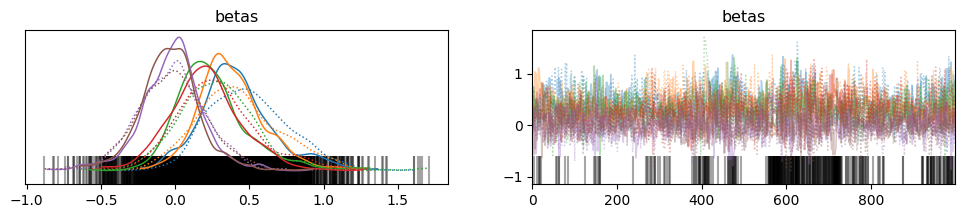

In [84]:
az.plot_trace(trace, var_names=['betas'])
az.summary(trace, var_names=["betas"],hdi_prob=0.95)


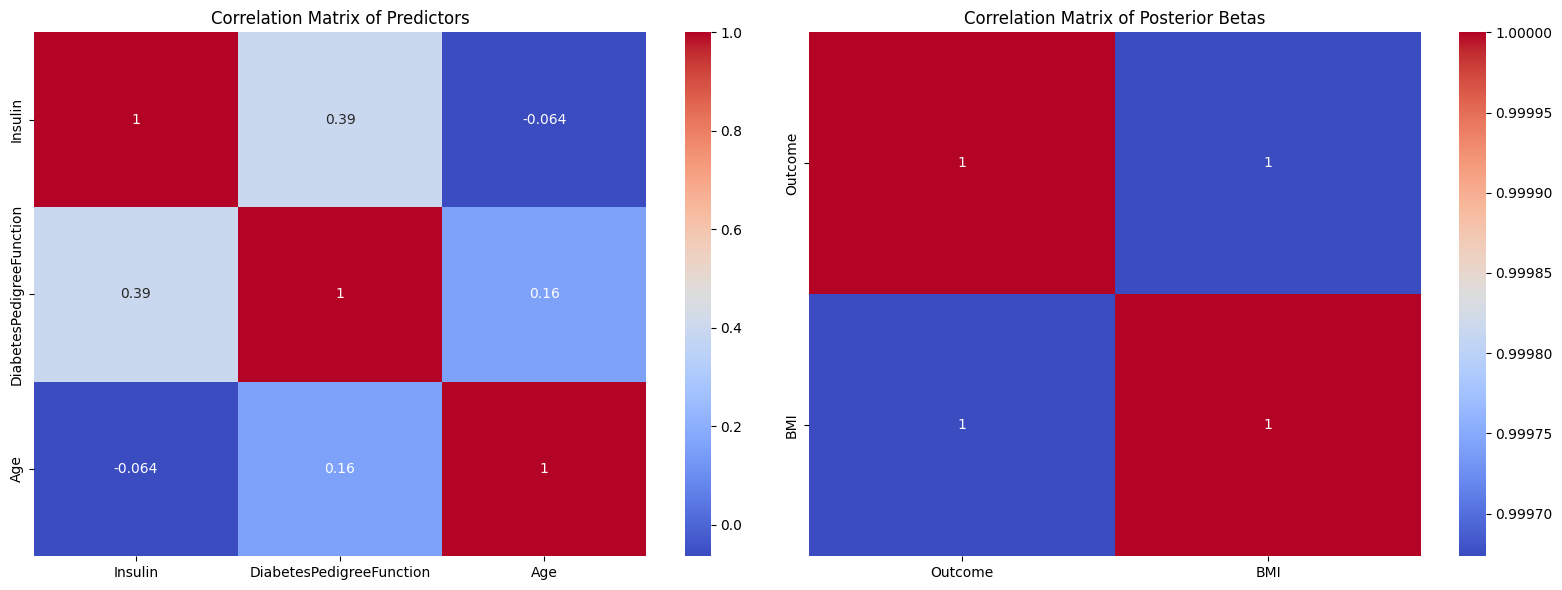

In [70]:
# Standardized predictors (X_standardized)
# Compute correlation matrix for standardized predictors
corr_X = np.corrcoef(X_standardized.T)  # Shape: (3, 3)

# Compute the correlation matrix for posterior samples of betas
betas_samples = trace.posterior['betas'].values  # Shape: (2, 1000, 3)

# Mean of the posterior betas across chains and samples
mean_betas = betas_samples.mean(axis=(0, 1))  # Shape: (3, 2) -- 3 predictors, 2 outcomes

# Compute the correlation matrix for betas (predictor coefficients)
corr_betas = np.corrcoef(mean_betas.T)  # Shape: (2, 2) for the two outcomes

# Plotting the correlation matrices

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Visualize correlation matrix of predictors (X)
sns.heatmap(corr_X, annot=True, cmap='coolwarm', xticklabels=X_columns, yticklabels=X_columns, ax=ax[0])
ax[0].set_title("Correlation Matrix of Predictors")

# Visualize correlation matrix of posterior betas
sns.heatmap(corr_betas, annot=True, cmap='coolwarm', xticklabels=Y_columns, yticklabels=Y_columns, ax=ax[1])
ax[1].set_title("Correlation Matrix of Posterior Betas")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


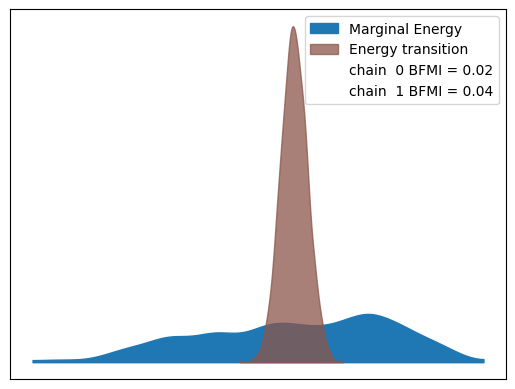

In [89]:
az.plot_energy(trace)
plt.show()

# Conculsion
Parameter: betas[0, 0]
  - Mean: 0.458
  - Standard Deviation: 0.266
  - HDI 2.5%: -0.057
  - HDI 97.5%: 0.985
  - MCSE Mean: 0.020
  - MCSE SD: 0.015
  - ESS Bulk: 186.0
  - ESS Tail: 307.0
  - R_hat: 1.01

Parameter: betas[0, 1]
  - Mean: 0.405
  - Standard Deviation: 0.257
  - HDI 2.5%: -0.091
  - HDI 97.5%: 0.941
  - MCSE Mean: 0.019
  - MCSE SD: 0.016
  - ESS Bulk: 228.0
  - ESS Tail: 453.0
  - R_hat: 1.02

Parameter: betas[1, 0]
  - Mean: 0.269
  - Standard Deviation: 0.264
  - HDI 2.5%: -0.236
  - HDI 97.5%: 0.795
  - MCSE Mean: 0.016
  - MCSE SD: 0.014
  - ESS Bulk: 384.0
  - ESS Tail: 389.0
  - R_hat: 1.00

Parameter: betas[1, 1]
  - Mean: 0.244
  - Standard Deviation: 0.262
  - HDI 2.5%: -0.242
  - HDI 97.5%: 0.810
  - MCSE Mean: 0.040
  - MCSE SD: 0.029
  - ESS Bulk: 59.0
  - ESS Tail: 144.0
  - R_hat: 1.04

Parameter: betas[2, 0]
  - Mean: -0.022
  - Standard Deviation: 0.218
  - HDI 2.5%: -0.448
  - HDI 97.5%: 0.425
  - MCSE Mean: 0.009
  - MCSE SD: 0.008
  - ESS Bulk: 653.0
  - ESS Tail: 507.0
  - R_hat: 1.00

Parameter: betas[2, 1]
  - Mean: -0.027
  - Standard Deviation: 0.221
  - HDI 2.5%: -0.461
  - HDI 97.5%: 0.422
  - MCSE Mean: 0.009
  - MCSE SD: 0.015
  - ESS Bulk: 601.0
  - ESS Tail: 250.0
  - R_hat: 1.02

All of them have R-hat values that are close to one , indicating good convergence. <br>
Betas[1, 1] seems to have both low ess values (ess_bulk->59) and a high MCSE Mean of 0.040 compared to other betas suggesting potential issues with the accuracy of the mean estimate for this parameter.